# Fourier Ptychography reconstruction of an EUV phase defect
Here we show.
The code is self-contained, and the data has been pre-processed (drift correction, background removal, and slight rotation)

-- Antoine Wojdyla
(This code is a direct port from a Matlab script; there might be errors)


It is recommended to use Anaconda (it was tested on python 3.6)
I you miss some of the packages, you might run `pip install {packagename}`

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Parameters

In [2]:
# folder 
data_folder = "defect_5um/fp_data/"
# effective pixel size
px_m = 15e-9
# wavelength
lambda_m = 13.5e-9
# numerical aperture of the objective lens
NA = 0.33/4

## Load the data

In [3]:
filenames = os.listdir(data_folder)
images = ()
x_npc = ()
y_npc = ()
for i in np.arange(len(filenames)):
    # scanning the filenames
    filename = filenames[i]
    # opening the images
    img = Image.open(data_folder+filename)
    # appending the images to the list
    images += (img,)
    # normalized pupil coordinate corresponding to each image
    x_npc  += (float(filename[filename.rfind('sx')+2:filename.rfind('sx')+6]),)
    y_npc  += (float(filename[filename.rfind('sy')+2:filename.rfind('sy')+6]),)

## Some useful functions

In [4]:
# frequency scale
def fs(t):
    fs = 1/(t[1]-t[0])
    Nfft = len(t)
    df = fs/Nfft
    f =  np.arange(0,fs,df) - (fs-np.mod(Nfft,2)*df)/2
    return f

# centered Fourier Transform
def ft(img):
    return np.fft.fftshift( np.fft.ifft2( np.fft.ifftshift( img ) ) )

# centered Inverse Fourier Transform
def ift(IMG):
    return np.fft.fftshift( np.fft.fft2( np.fft.ifftshift( IMG ) ) )

# shifting an array id 2D
def shift(img, x_px, y_px):
    return np.roll(np.roll(img,x_px,axis=1),y_px,axis=0)
    

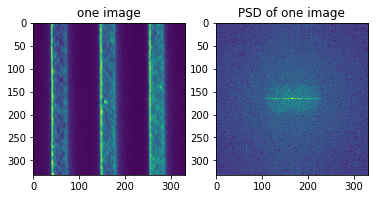

In [39]:
idx = 14
plt.subplot(1,2,1)
plt.imshow(np.asarray(images[idx]))
plt.title('one image')
plt.subplot(1,2,2)
plt.imshow(abs(ift(np.asarray(images[idx])))**0.1)
plt.title('PSD of one image')
plt.show()


plt.show()

## Physical scaling 

In [6]:
Nx_px = np.asarray(images[0]).shape[0]
Ny_px = np.asarray(images[0]).shape[1]
# spatial scale
x_m = np.arange(Nx_px)*px_m
y_m = np.arange(Ny_px)*px_m
# frequency scale
fx_cpm = fs(x_m)
fy_cpm = fs(y_m)
Fx,Fy = np.meshgrid(fx_cpm,fy_cpm)

## Initial guess and pupil estimate

In [40]:
idx00 = 39
E_guess = np.sqrt(np.asarray(images[idx00]))
P_guess = np.zeros((Nx_px,Ny_px))
# Pupil max radius limited by lens numerical aperture
fc_cpm = np.arcsin(NA)/lambda_m
P_guess[np.where(Fx**2+Fy**2<fc_cpm**2)] = 1

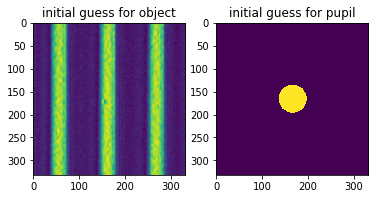

In [41]:
plt.subplot(1,2,1)
plt.imshow(np.abs(E_guess))
plt.title('initial guess for object')
plt.subplot(1,2,2)
plt.imshow(P_guess)
plt.title('initial guess for pupil')
plt.show()

## Fourier Ptychography iterative reconstruction

In [9]:
# update rate parameters
alpha = 1
beta  = 1

# noise level
delta = 10;

# general loop
for k in np.arange(2):
    # data loop
    for i in np.arange(len(images)):
        
        # linear update
        #idx = i;
        # random update
        idx = int(np.floor(np.random.rand()*len(images)))
        
        # current image for update
        img = np.asarray(images[idx])
        
        # pixel shifts to move the pupil arounf
        X0 = int(np.round((x_npc[idx]*fc_cpm*Nx_px*px_m)))
        Y0 = int(np.round((y_npc[idx]*fc_cpm*Nx_px*px_m)))
        
        o_n = E_guess
        P_n = P_guess

        Psi_n = P_n*shift(ft(o_n), -X0, -Y0)

        # impose intensity constraint
        psi_n = ift(Psi_n)
        phi_np = np.sqrt(img)*np.exp(1j*np.angle(psi_n))

        # update auxiliary function
        Phi_np = ft(phi_np)

        #object update
        O_p = (shift(P_n,X0,Y0)*np.conj(shift(P_n,X0,Y0))
               /(np.max(np.abs(P_n)**2)*(np.abs(shift(P_n,X0,Y0))**2+delta))
               *(shift(Phi_np,X0,Y0)-shift(Psi_n,X0,Y0)));
        O_np = ift(ft(o_n) + alpha*O_p)

        #lens update
        P_p = (shift(ft(o_n),-X0,-Y0)*np.conj(shift(ft(o_n),-X0,-Y0))
               /(np.max(np.abs(shift(ft(o_n),-X0,-Y0))**2)*(np.abs(shift(ft(o_n),-X0,-Y0))**2)+delta)
               *(Phi_np-Psi_n))
        P_np = P_n + beta*P_p

        # 
        E_guess = O_np;
        P_guess  =  P_np;

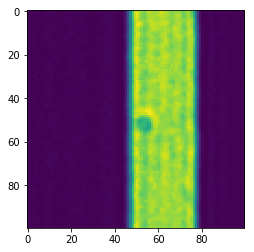

In [10]:
plt.imshow(np.abs(E_guess)**2)
plt.imshow(np.abs(E_guess[120:220,100:200])**2)
#plt.imshow(np.angle(E_guess))
plt.show()

Caveats:
There is no rescaling needed

In [15]:
# another way to import images
import skimage
skimage.io.imread(data_folder+filename)

## Applying a defocus (numerically)

In [33]:
# Propagation using Fourier Optics
def propagate(E_in, L_m, lambda_m, z_m):
    Nx = E_in.shape[1]
    Ny = E_in.shape[0]
    # sample interval
    dx=L_m/Nx
    # wavenumber
    k=2*np.pi/lambda_m; 
    if dx<lambda_m*z_m/L_m:
        pass

    fx_cpm = fs(np.linspace(0,L_m,Nx))
    fy_cpm = fs(np.linspace(0,L_m,Ny))
    Fx, Fy = np.meshgrid(fx_cpm, fy_cpm)
    
    # Free space propagating Kkrnel
    H=np.exp(-1j*np.pi*lambda_m*z_m*(Fx**2+Fy**2))
    E_out = ift(H*ft(E_in))
    return E_out

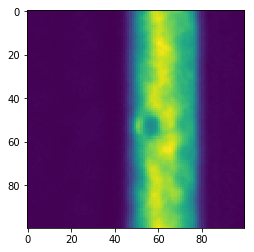

In [42]:
# amount of defocus (must be <10um otherwise there's aliasing)
z_m = -400e-9

E_defoc = propagate(E_guess,Nx_px*px_m,lambda_m,z_m)
I_defoc = np.abs(E_defoc)**2

plt.imshow(I_defoc[120:220,100:200])
plt.show()